In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold,RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Load Titanic datasets
train_df = pd.read_csv(r"data\train.csv")
test_df = pd.read_csv(r"data\test.csv")

# Preview first 5 rows
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Summary of training dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
# Check dimensions of training and test datasets
print(f"Shape of training data: {train_df.shape}")
print(f"Shape of testing data: {test_df.shape}")

Shape of training data: (891, 12)
Shape of testing data: (418, 11)


In [5]:
# Inspect rows with missing Age values
train_df[train_df['Age'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


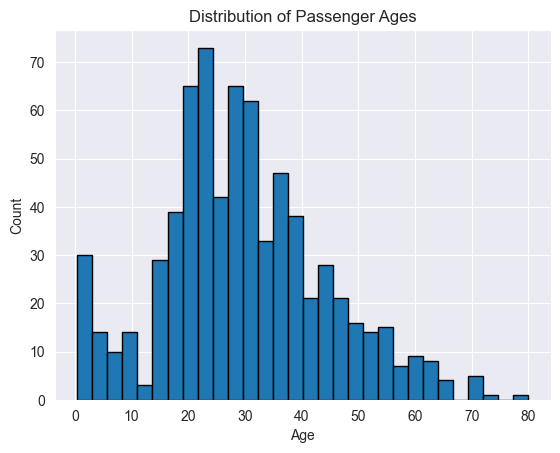

In [6]:
# Plot Age distribution
train_df['Age'].dropna().hist(bins=30, edgecolor="black")
plt.title("Distribution of Passenger Ages")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

In [7]:
# Preview Pclass vs Cabin
train_df[["Pclass","Cabin"]].head(891)

,Pclass,Cabin
0,3,NaN
1,1,C85
2,3,NaN
3,1,C123
4,3,NaN
...,...,...
886,2,NaN
887,1,B42
888,3,NaN
889,1,C148


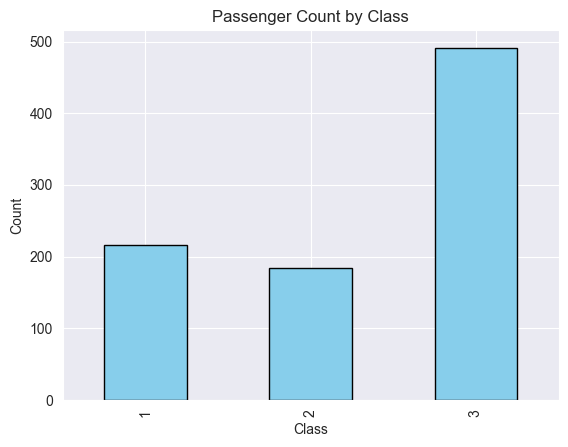

In [8]:
# Bar plot of passenger classes
train_df['Pclass'].value_counts().sort_index().plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Passenger Count by Class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [9]:
# Checking unique cabin letters across passenger classes
Pclass_1 =[]
Pclass_2 =[]
Pclass_3 =[]
for index, row in train_df[["Pclass","Cabin"]].iterrows():
    cabin = row["Cabin"]
    pclass = row["Pclass"]

    if pd.isna(cabin):
        continue

    chars = []
    if pclass == 1:
        if cabin[0] in Pclass_1:
            continue
        for char in cabin:
            if char.isalpha():
                chars.append(char)
        if len(chars) == 1:
            Pclass_1.append(cabin[0])
        else:
            Pclass_1.append(chars)
    elif pclass == 2:
        if cabin[0] in Pclass_2:
            continue
        for char in cabin:
            if char.isalpha():
                chars.append(char)
        if len(chars) == 1:
            Pclass_2.append(cabin[0])
        else:
            Pclass_2.append(chars)
    else:
        if cabin[0] in Pclass_3:
            continue
        for char in cabin:
            if char.isalpha():
                chars.append(char)
        if len(chars) == 1:
            Pclass_3.append(cabin[0])
        else:
            Pclass_3.append(chars)

print(f"Class 1: {Pclass_1}\n Class 2: {Pclass_2}\nClass 3: {Pclass_3}")

Class 1: ['C', 'E', 'A', 'B', 'D', 'T']
 Class 2: ['D', 'F', 'E']
Class 3: ['G', ['F', 'G'], ['F', 'E'], 'E', ['F', 'G'], ['F', 'G'], 'F']


In [10]:
#Extract first letter of Cabin (deck indicator)
train_df['CabinLetter'] = train_df['Cabin'].fillna("Unknown").str[0]
test_df['CabinLetter'] = test_df['Cabin'].fillna("Unknown").str[0]

# Preview new feature
train_df[['Cabin', 'CabinLetter']].head()


,Cabin,CabinLetter
0,NaN,U
1,C85,C
2,NaN,U
3,C123,C
4,NaN,U


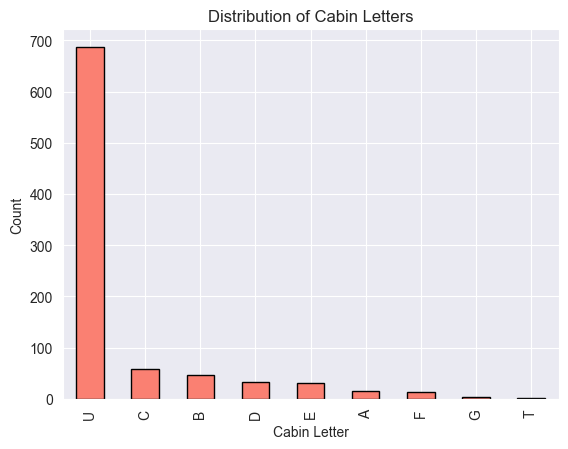

In [11]:
# Plot distribution of cabin letters (deck levels)
train_df['CabinLetter'].value_counts().plot(kind="bar", color="salmon", edgecolor="black")
plt.title("Distribution of Cabin Letters")
plt.xlabel("Cabin Letter")
plt.ylabel("Count")
plt.show()

In [12]:
Pclass_1 =[]
Pclass_2 =[]
Pclass_3 =[]
for index, row in train_df[["Pclass","Cabin"]].iterrows():
    cabin = row["Cabin"]
    pclass = row["Pclass"]

    if pd.isna(cabin):
        continue

    chars = []
    if pclass == 1:
        for char in cabin:
            if char.isalpha():
                chars.append(char)
        if len(chars) > 1:
            Pclass_1.append(chars)
    elif pclass == 2:
        for char in cabin:
            if char.isalpha():
                chars.append(char)
        if len(chars) > 1:
            Pclass_2.append(chars)
    else:
        for char in cabin:
            if char.isalpha():
                chars.append(char)
        if len(chars) > 1:
            Pclass_3.append(chars)

print(f"Class 1: {Pclass_1}\n Class 2: {Pclass_2}\nClass 3: {Pclass_3}")

Class 1: [['C', 'C', 'C'], ['C', 'C', 'C'], ['D', 'D'], ['B', 'B'], ['C', 'C'], ['B', 'B'], ['C', 'C'], ['B', 'B', 'B', 'B'], ['C', 'C', 'C'], ['B', 'B'], ['B', 'B'], ['C', 'C', 'C'], ['C', 'C'], ['B', 'B', 'B'], ['C', 'C'], ['B', 'B', 'B', 'B'], ['B', 'B'], ['B', 'B'], ['B', 'B'], ['B', 'B', 'B']]
 Class 2: []
Class 3: [['F', 'G'], ['F', 'E'], ['F', 'G'], ['F', 'G']]


In [13]:
#All letter cabins
Pclass = []
for index, row in train_df[["Pclass","Cabin"]].iterrows():
    cabin = row["Cabin"]
    pclass = row["Pclass"]

    if pd.isna(cabin):
        Pclass.append(cabin)
        continue

    chars = []
    if pclass == 1:
        for char in cabin:
            if char.isalpha():
                chars.append(char)
        if len(chars) == 1:
            Pclass.append(cabin[0])
        else:
            Pclass.append(chars)
    elif pclass == 2:
        for char in cabin:
            if char.isalpha():
                chars.append(char)
        if len(chars) == 1:
            Pclass.append(cabin[0])
        else:
            Pclass.append(chars)
    else:
        for char in cabin:
            if char.isalpha():
                chars.append(char)
        if len(chars) == 1:
            Pclass.append(cabin[0])
        else:
            Pclass.append(chars)

print(f"PClass: {Pclass}")


PClass: [nan, 'C', nan, 'C', nan, nan, 'E', nan, nan, nan, 'G', 'C', nan, nan, nan, nan, nan, nan, nan, nan, nan, 'D', nan, 'A', nan, nan, nan, ['C', 'C', 'C'], nan, nan, nan, 'B', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 'D', nan, 'B', 'C', nan, nan, nan, nan, nan, 'B', 'C', nan, nan, nan, 'F', nan, nan, nan, nan, nan, nan, nan, nan, ['F', 'G'], nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, ['C', 'C', 'C'], nan, nan, nan, 'E', nan, nan, nan, 'A', ['D', 'D'], nan, nan, nan, nan, 'D', nan, nan, nan, nan, nan, nan, nan, 'C', nan, nan, nan, nan, nan, nan, nan, ['B', 'B'], nan, nan, nan, nan, 'E', 'D', nan, nan, nan, ['F', 'E'], nan, nan, nan, nan, nan, nan, nan, 'D', 'C', nan, 'B', nan, nan, nan, nan, nan, nan, nan, nan, 'F', nan, nan, 'C', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 'E', nan, nan, nan, 'B', nan, nan, nan, 'A', nan, nan, 'C', nan, nan, nan, nan, nan, 'F', nan, 'A', nan, nan,

In [14]:
#Debug check
#print(len(Pclass_1[0]))

In [15]:
#Registered cabin(True) vs Not(False)
has_cabin = train_df['Cabin'].isna()
has_cabin

0       True
1      False
2       True
3      False
4       True
       ...  
886     True
887    False
888     True
889    False
890     True
Name: Cabin, Length: 891, dtype: bool

In [16]:
cabins_count_list = []
for cabin in Pclass:
    if cabin != cabin:
        cabins_count_list.append(0)
        continue
    else:
        cabins_count_list.append(len(cabin))
print(cabins_count_list)

[0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 1, 2, 0, 0, 0, 1, 0, 2, 0, 1, 0, 1, 1, 4, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 

In [17]:
cabins_count = pd.DataFrame(cabins_count_list, columns=['Cabin_Count'])
cabins_count

,Cabin_Count
0,0
1,1
2,0
3,1
4,0
...,...
886,0
887,1
888,0
889,1


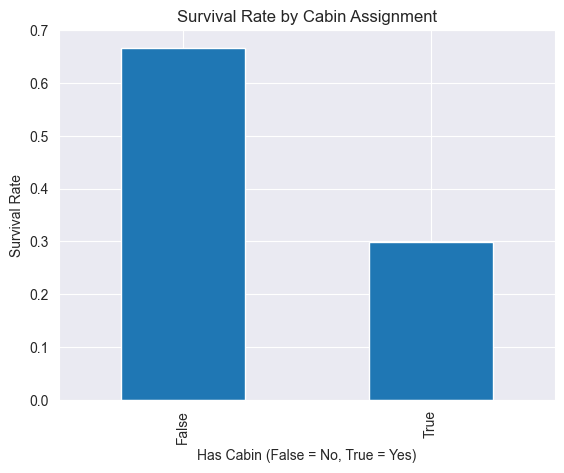

In [18]:
# Convert True/False to labels for plotting
train_df.groupby(has_cabin)['Survived'].mean().plot(kind="bar")
plt.title("Survival Rate by Cabin Assignment")
plt.xlabel("Has Cabin (False = No, True = Yes)")
plt.ylabel("Survival Rate")
plt.show()

In [19]:
train_df = pd.concat([train_df, has_cabin, cabins_count], axis=1)
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinLetter,Cabin,Cabin_Count
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,U,True,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,False,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,U,True,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,False,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,U,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,U,True,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,B,False,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,U,True,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,C,False,1


In [20]:
cleaned_cabins_list = [x if not x != x else 'Z' for x in Pclass]
cleaned_cabins_list

['Z',
 'C',
 'Z',
 'C',
 'Z',
 'Z',
 'E',
 'Z',
 'Z',
 'Z',
 'G',
 'C',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'D',
 'Z',
 'A',
 'Z',
 'Z',
 'Z',
 ['C', 'C', 'C'],
 'Z',
 'Z',
 'Z',
 'B',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'D',
 'Z',
 'B',
 'C',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'B',
 'C',
 'Z',
 'Z',
 'Z',
 'F',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 ['F', 'G'],
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 ['C', 'C', 'C'],
 'Z',
 'Z',
 'Z',
 'E',
 'Z',
 'Z',
 'Z',
 'A',
 ['D', 'D'],
 'Z',
 'Z',
 'Z',
 'Z',
 'D',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'C',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 ['B', 'B'],
 'Z',
 'Z',
 'Z',
 'Z',
 'E',
 'D',
 'Z',
 'Z',
 'Z',
 ['F', 'E'],
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'D',
 'C',
 'Z',
 'B',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'F',
 'Z',
 'Z',
 'C',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',


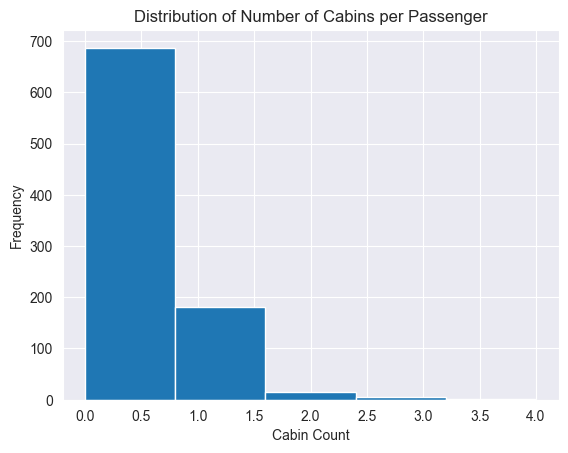

In [21]:
# Plot histogram of cabin counts
train_df['Cabin_Count'].hist(bins=5)
plt.title("Distribution of Number of Cabins per Passenger")
plt.xlabel("Cabin Count")
plt.ylabel("Frequency")
plt.show()

In [22]:
mlb = MultiLabelBinarizer()
encoded_decks = mlb.fit_transform(cleaned_cabins_list)
column_names = mlb.classes_

encoded_df = pd.DataFrame(encoded_decks, columns=column_names, index=train_df.index)
# # First, get a list of the columns that are causing the overlap
# overlapping_columns = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'Z']
#
# # Drop those columns from the original DataFrame before joining
# train_df.drop(columns=overlapping_columns, inplace=True)
train_df = train_df.join(encoded_df)
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_Count,A,B,C,D,E,F,G,T,Z
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,1,0,0,1,0,0,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,1,0,0,1,0,0,0,0,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,...,0,0,0,0,0,0,0,0,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,...,1,0,1,0,0,0,0,0,0,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,...,0,0,0,0,0,0,0,0,0,1
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,...,1,0,0,1,0,0,0,0,0,0


In [23]:
train_df.drop(["Cabin", 'Z'], axis=1, inplace=True)
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,CabinLetter,Cabin_Count,A,B,C,D,E,F,G,T
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,U,0,0,0,0,0,0,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,C,1,0,0,1,0,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,U,0,0,0,0,0,0,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,C,1,0,0,1,0,0,0,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,U,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,...,U,0,0,0,0,0,0,0,0,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,...,B,1,0,1,0,0,0,0,0,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,...,U,0,0,0,0,0,0,0,0,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,...,C,1,0,0,1,0,0,0,0,0


In [24]:
print(train_df.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'CabinLetter', 'Cabin_Count',
       'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'],
      dtype='object')


In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     889 non-null    object 
 11  CabinLetter  891 non-null    object 
 12  Cabin_Count  891 non-null    int64  
 13  A            891 non-null    int64  
 14  B            891 non-null    int64  
 15  C            891 non-null    int64  
 16  D            891 non-null    int64  
 17  E            891 non-null    int64  
 18  F            891 non-null    int64  
 19  G       

In [26]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinLetter
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,U
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,U
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,U
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,U
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,U


In [27]:
# All letter cabins for test_df
Pclass_test = []
for index, row in test_df[["Pclass", "Cabin"]].iterrows():
    cabin = row["Cabin"]
    pclass = row["Pclass"]

    if pd.isna(cabin):
        Pclass_test.append(cabin)
        continue

    chars = []
    for char in cabin:
        if char.isalpha():
            chars.append(char)
    if len(chars) == 1:
        Pclass_test.append(cabin[0])
    else:
        Pclass_test.append(chars)
Pclass_test

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 'B',
 nan,
 'E',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 ['B', 'B', 'B', 'B'],
 nan,
 'B',
 nan,
 'A',
 nan,
 nan,
 nan,
 nan,
 nan,
 'C',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 'D',
 nan,
 nan,
 'D',
 nan,
 'A',
 nan,
 'D',
 nan,
 'C',
 nan,
 nan,
 ['C', 'C', 'C'],
 nan,
 nan,
 nan,
 ['F', 'G'],
 nan,
 'B',
 nan,
 nan,
 nan,
 nan,
 ['B', 'B', 'B', 'B'],
 nan,
 nan,
 nan,
 'C',
 ['C', 'C', 'C'],
 nan,
 nan,
 nan,
 'D',
 'C',
 'C',
 nan,
 'C',
 nan,
 nan,
 nan,
 ['C', 'C'],
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 'B',
 nan,
 nan,
 nan,
 'C',
 nan,
 nan,
 nan,
 'C',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 'F',
 nan,
 nan,
 'A',
 nan,
 ['C', 'C'],
 nan,
 nan,
 'G',
 'C',
 nan,
 nan,
 nan,
 'C',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 'C',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 ['B', 'B', 'B', 'B'],
 nan,
 nan,
 nan,
 'E',
 nan,
 nan,
 nan,
 'C'

In [28]:

# Cabin counts for test set
test_cabins_count_list = []
for cabin in Pclass_test:
    if cabin != cabin:
        test_cabins_count_list.append(0)
        continue
    else:
        test_cabins_count_list.append(len(cabin))
print(test_cabins_count_list)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 3, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 4, 0, 0, 0, 1, 3, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 

In [29]:
test_cabins_count = pd.DataFrame(test_cabins_count_list, columns=['Cabin_Count'])
test_cabins_count

,Cabin_Count
0,0
1,0
2,0
3,0
4,0
...,...
413,0
414,1
415,0
416,0


In [30]:
# Add Cabin_Count to test set
test_df = pd.concat([test_df, test_cabins_count], axis=1)
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinLetter,Cabin_Count
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,U,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,U,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,U,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,U,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,U,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,U,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,C,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,U,0
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,U,0


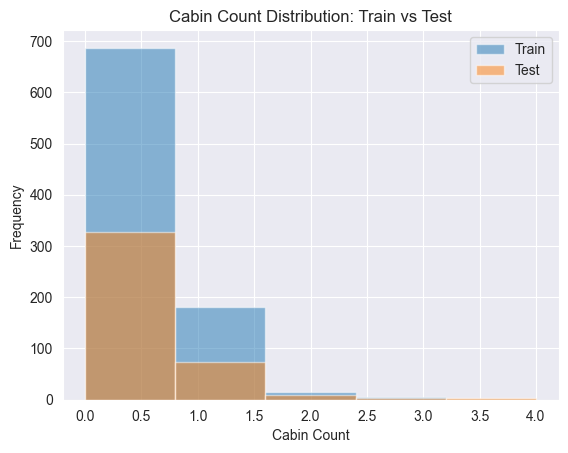

In [31]:
# Compare Cabin_Count distribution between train and test
plt.hist(train_df['Cabin_Count'], bins=5, alpha=0.5, label="Train")
plt.hist(test_df['Cabin_Count'], bins=5, alpha=0.5, label="Test")
plt.title("Cabin Count Distribution: Train vs Test")
plt.xlabel("Cabin Count")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [32]:
cleaned_test_cabins_list = [x if not x != x else 'Z' for x in Pclass_test]
cleaned_test_cabins_list

['Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'B',
 'Z',
 'E',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 ['B', 'B', 'B', 'B'],
 'Z',
 'B',
 'Z',
 'A',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'C',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'D',
 'Z',
 'Z',
 'D',
 'Z',
 'A',
 'Z',
 'D',
 'Z',
 'C',
 'Z',
 'Z',
 ['C', 'C', 'C'],
 'Z',
 'Z',
 'Z',
 ['F', 'G'],
 'Z',
 'B',
 'Z',
 'Z',
 'Z',
 'Z',
 ['B', 'B', 'B', 'B'],
 'Z',
 'Z',
 'Z',
 'C',
 ['C', 'C', 'C'],
 'Z',
 'Z',
 'Z',
 'D',
 'C',
 'C',
 'Z',
 'C',
 'Z',
 'Z',
 'Z',
 ['C', 'C'],
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'B',
 'Z',
 'Z',
 'Z',
 'C',
 'Z',
 'Z',
 'Z',
 'C',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'F',
 'Z',
 'Z',
 'A',
 'Z',
 ['C', 'C'],
 'Z',
 'Z',
 'G',
 'C',
 'Z',
 'Z',
 'Z',
 'C',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'C',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 ['B', 'B', 'B', 'B'],
 'Z',
 'Z',
 'Z',
 'E',
 'Z',
 'Z',
 'Z',
 'C'

In [33]:
test_mlb = MultiLabelBinarizer()
encoded_test_decks = test_mlb.fit_transform(cleaned_test_cabins_list)
test_column_names = test_mlb.classes_

encoded_test_df = pd.DataFrame(encoded_test_decks, columns=test_column_names, index=test_df.index)
# # First, get a list of the columns that are causing the overlap
# overlapping_columns = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'Z']
#
# # Drop those columns from the original DataFrame before joining
# train_df.drop(columns=overlapping_columns, inplace=True)
test_df = test_df.join(encoded_test_df)
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,CabinLetter,Cabin_Count,A,B,C,D,E,F,G,Z
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,...,U,0,0,0,0,0,0,0,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,...,U,0,0,0,0,0,0,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,...,U,0,0,0,0,0,0,0,0,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,...,U,0,0,0,0,0,0,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,...,U,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,...,U,0,0,0,0,0,0,0,0,1
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,...,C,1,0,0,1,0,0,0,0,0
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,...,U,0,0,0,0,0,0,0,0,1
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,...,U,0,0,0,0,0,0,0,0,1


In [34]:
test_df.drop(["Cabin", 'Z'], axis=1, inplace=True)
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,CabinLetter,Cabin_Count,A,B,C,D,E,F,G
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,U,0,0,0,0,0,0,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,U,0,0,0,0,0,0,0,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,U,0,0,0,0,0,0,0,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,U,0,0,0,0,0,0,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,U,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,S,U,0,0,0,0,0,0,0,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,C,1,0,0,1,0,0,0,0
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,U,0,0,0,0,0,0,0,0
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,S,U,0,0,0,0,0,0,0,0


In [35]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,CabinLetter,Cabin_Count,A,B,C,D,E,F,G,T
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,U,0,0,0,0,0,0,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,C,1,0,0,1,0,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,U,0,0,0,0,0,0,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,C,1,0,0,1,0,0,0,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,U,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,...,U,0,0,0,0,0,0,0,0,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,...,B,1,0,1,0,0,0,0,0,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,...,U,0,0,0,0,0,0,0,0,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,...,C,1,0,0,1,0,0,0,0,0


In [36]:
print(train_df.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'CabinLetter', 'Cabin_Count',
       'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'],
      dtype='object')


In [37]:
X = train_df.drop(['PassengerId','Survived', 'Name', 'Ticket'], axis=1, inplace=False)
y = train_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_main_test = test_df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=False)

numerical_columns = ['Age', 'Fare']
categorical_columns = ['Sex', 'Embarked']

numerical_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
]) # Age, Fare

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
]) # Sex, Embarked

preprocessor = ColumnTransformer(transformers=[
    ('num_transformer', numerical_transformer, numerical_columns),
    ('cat_transformer', categorical_transformer, categorical_columns)
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")

Accuracy Score: 0.7713004484304933


In [44]:
kfold = StratifiedKFold(n_splits=5)
scores = cross_val_score(pipeline, X, y, cv=kfold)

print(f'Scores: {scores}')
print(f'Average: {scores.mean()}')

Scores: [0.79329609 0.80337079 0.75842697 0.75280899 0.79213483]
Average: 0.7800075324838366


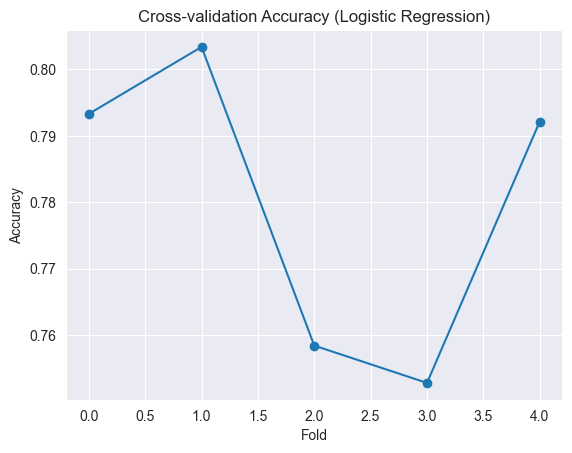

In [45]:
# Plot Cross-val Accuracy
plt.plot(scores, marker='o')
plt.title("Cross-validation Accuracy (Logistic Regression)")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.show()


In [40]:
param_grid = {
    'preprocessor__num_transformer__num_imputer__strategy': ['median', 'mean'],
    'classifier__C': np.logspace(0.1, 2.0, 30)
}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=kfold)
grid_search.fit(X, y)

print("Best parameters:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)

Best parameters: {'classifier__C': np.float64(1.2589254117941673), 'preprocessor__num_transformer__num_imputer__strategy': 'median'}
Best CV score: 0.7799949783441089


In [41]:
# Define the parameter grids for each model
param_grid_logreg = {
    'preprocessor__num_transformer__num_imputer__strategy': ['median', 'mean'],
    'classifier': [LogisticRegression()],
    'classifier__C': np.logspace(-4, 2, 10)
}

param_grid_dt = {
    'preprocessor__num_transformer__num_imputer__strategy': ['median', 'mean'],
    'classifier': [DecisionTreeClassifier()],
    'classifier__max_depth': [3, 5, 10],
    'classifier__min_samples_split': [2, 5, 10]
}

param_grid_rf = {
    'preprocessor__num_transformer__num_imputer__strategy': ['median', 'mean'],
    'classifier': [RandomForestClassifier()],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 5, 10]
}

param_grid_xgb = {
    'preprocessor__num_transformer__num_imputer__strategy': ['median', 'mean'],
    'classifier': [XGBClassifier(random_state=42)],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 5, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.2]
}

# Combine the parameter grids for a single search
param_grids = [param_grid_logreg, param_grid_dt, param_grid_rf, param_grid_xgb]

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grids, cv=kfold, verbose=1)
grid_search.fit(X, y)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)

Fitting 5 folds for each of 110 candidates, totalling 550 fits
Best parameters: {'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...), 'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'preprocessor__num_transformer__num_imputer__str

In [42]:
# Run grid search for each model
param_grids = [param_grid_logreg, param_grid_dt, param_grid_rf, param_grid_xgb]

for param_grid in param_grids:
    grid = GridSearchCV(pipeline, param_grid=param_grid, cv=kfold)
    grid.fit(X, y)
    model_name = type(grid.best_estimator_.named_steps['classifier']).__name__
    print(model_name)
    print(" Best params:", grid.best_params_)
    print(" Best CV score:", grid.best_score_)
    print("-" * 40)

LogisticRegression
 Best params: {'classifier': LogisticRegression(), 'classifier__C': np.float64(0.046415888336127774), 'preprocessor__num_transformer__num_imputer__strategy': 'median'}
 Best CV score: 0.7811374050593183
----------------------------------------
DecisionTreeClassifier
 Best params: {'classifier': DecisionTreeClassifier(), 'classifier__max_depth': 5, 'classifier__min_samples_split': 5, 'preprocessor__num_transformer__num_imputer__strategy': 'median'}
 Best CV score: 0.7889837423890528
----------------------------------------
RandomForestClassifier
 Best params: {'classifier': RandomForestClassifier(), 'classifier__max_depth': 10, 'classifier__n_estimators': 50, 'preprocessor__num_transformer__num_imputer__strategy': 'mean'}
 Best CV score: 0.8092147385600402
----------------------------------------
XGBClassifier
 Best params: {'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
         

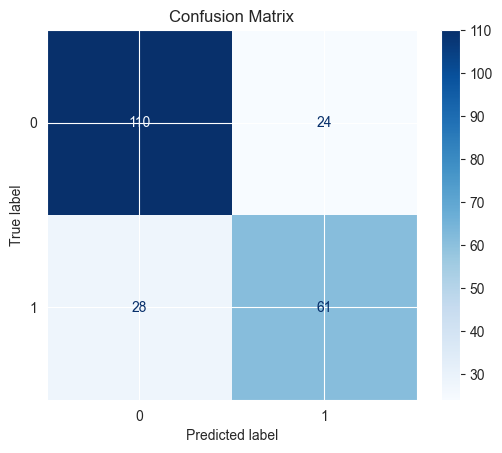

In [43]:
# Fit the pipeline with the best parameters from grid search
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Predict on validation split
y_pred = best_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()
